# Corrigindo

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, roc_curve
from matplotlib import pyplot

In [50]:
df = pd.read_csv('credit_risk_dataset.csv', sep = ',')

In [51]:
y = df['loan_status']
X = df.drop('loan_status', axis=1)

In [52]:
dc = df.columns
numeric_vars = list(dc.drop(['loan_grade','loan_status', 'loan_intent', 'person_home_ownership', 'cb_person_default_on_file'] ))
categorical_vars = ['loan_intent', 'person_home_ownership', 'cb_person_default_on_file']  # Add your categorical column names here


numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder())
])

ordinal_transformer = Pipeline(steps=[
    ('encoder', OrdinalEncoder(categories=[['A', 'B', 'C', 'D', 'E', 'F', 'G']]))
])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_vars),
        ('cat', categorical_transformer, categorical_vars),
        ('ord', ordinal_transformer, ['loan_grade'] )],
        remainder='passthrough' 
        )

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['person_age',
                                                   'person_income',
                                                   'person_emp_length',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'loan_percent_income',
                                                   'cb_person_cred_hist_length']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['loan_intent',
                                                   'person_home_ownership',
                                                   'cb_person_default_on_file']),
                                                 ('ord',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder(categories=[['A',
                                                                                               'B',
                                                                                               'C',
                                                                                               'D',
                                                                                               'E',
                                                                                               'F',
                                                                                               'G']]))]),
                                                  ['loan_grade'])])),
                ('classifier', LogisticRegression())])

In [53]:
y_pred = pipeline.predict(X_test)

In [54]:
confusion = confusion_matrix(y_test, y_pred)
TP = confusion[1, 1]  # True Positives
TN = confusion[0, 0]  # True Negatives
FP = confusion[0, 1]  # False Positives
FN = confusion[1, 0]  # False Negatives

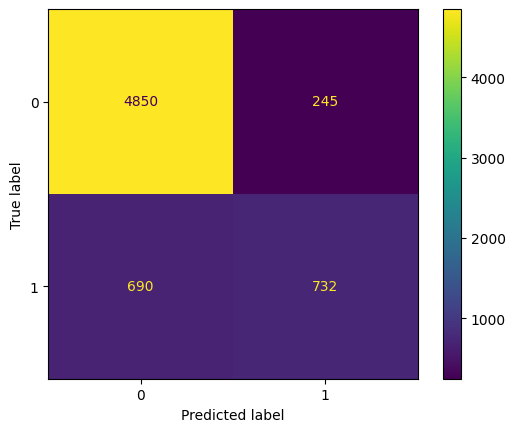

In [55]:

disp = ConfusionMatrixDisplay(confusion_matrix = confusion,
                              display_labels = pipeline.named_steps['classifier'].classes_)
disp.plot()
plt.show()

In [56]:
print('Precisão', TP/(TP + FP) )
print('Sensitividade', TP/(TP+FN))
print('Especificidade', TN/(TN+FP))
print('Acurácia', (TP+TN)/(TP+TN+FN+FP))

Precisão 0.7492323439099283
Sensitividade 0.5147679324894515
Especificidade 0.9519136408243376
Acurácia 0.8565290777965322


 ### O nosso modelo de regressão está um pouco melhor do que a aleatoriedade, como 80% do dataset original era de inadimplentes se dissermos que todo mundo é não inadimplentes vamos acertar 80% das vezes por conta disso, então seria é recomendado procurar outros modelos melhores, vamos tentar um arvore de decisão.

In [75]:
y = df['loan_status']
X = df.drop('loan_status', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [76]:

models = {
    'DecisionTreeClassifier': DecisionTreeClassifier()
}

param_grid = {
    'DecisionTreeClassifier': {
        'classifier__max_depth': [None, 10, 20],
        'classifier__min_samples_split': [2, 5, 10]
    }
}

# Crie um dicionário vazio para armazenar os resultados de desempenho dos modelos
results = {}

# Itere sobre os modelos e ajuste-os usando GridSearchCV
for model_name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    grid_search = GridSearchCV(pipeline, param_grid[model_name], cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    # Armazene os resultados no dicionário
    results[model_name] = {
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_
    }

# Avalie o desempenho dos modelos
for model_name, result in results.items():
    print(f"Model: {model_name}")
    print(f"Best Parameters: {result['best_params']}")
    print(f"Best Cross-Validation Score: {result['best_score']:.2f}\n")

# Escolha o modelo com o melhor desempenho com base nos resultados da validação cruzada
best_model_name = max(results, key=lambda key: results[key]['best_score'])
best_model = models[best_model_name]

# Treine o melhor modelo no conjunto de treinamento completo e avalie-o no conjunto de teste
best_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', best_model)
])

best_pipeline.fit(X_train, y_train)
test_score = best_pipeline.score(X_test, y_test)
print(f"Test Set Accuracy of the Best Model: {test_score:.2f}")


Model: DecisionTreeClassifier
Best Parameters: {'classifier__max_depth': 10, 'classifier__min_samples_split': 2}
Best Cross-Validation Score: 0.93

Test Set Accuracy of the Best Model: 0.89


In [119]:
for importance, name in sorted(zip(best_pipeline.named_steps['classifier'].feature_importances_, X_train.columns),reverse=True)[:5]:
    print (name, importance)

loan_grade 0.2356494199019439
person_income 0.12797512347508255
person_home_ownership 0.05719854378639804
loan_intent 0.05119752197096395
person_age 0.041227957408821944


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'num__loan_percent_income'),
  Text(1, 0, 'ord__loan_grade'),
  Text(2, 0, 'cat__person_home_ownership_RENT'),
  Text(3, 0, 'num__person_income'),
  Text(4, 0, 'num__person_emp_length')])

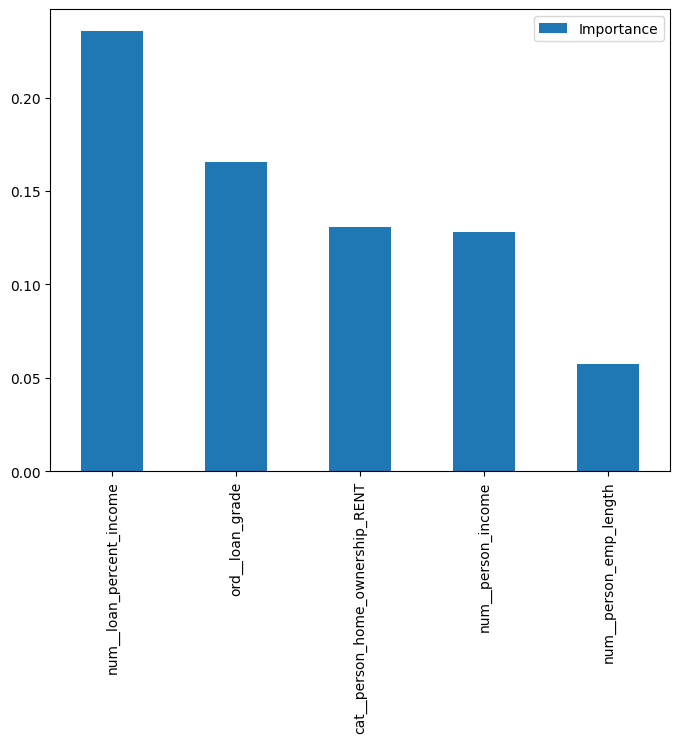

In [151]:
feat_importances = pd.DataFrame(best_pipeline.named_steps['classifier'].feature_importances_, index=best_pipeline.named_steps['preprocessor'].get_feature_names_out(), columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.head().plot(kind='bar', figsize=(8,6))
plt.xticks()

In [147]:
feat_importances.iloc[:,0]

AttributeError: 'Series' object has no attribute 'split'

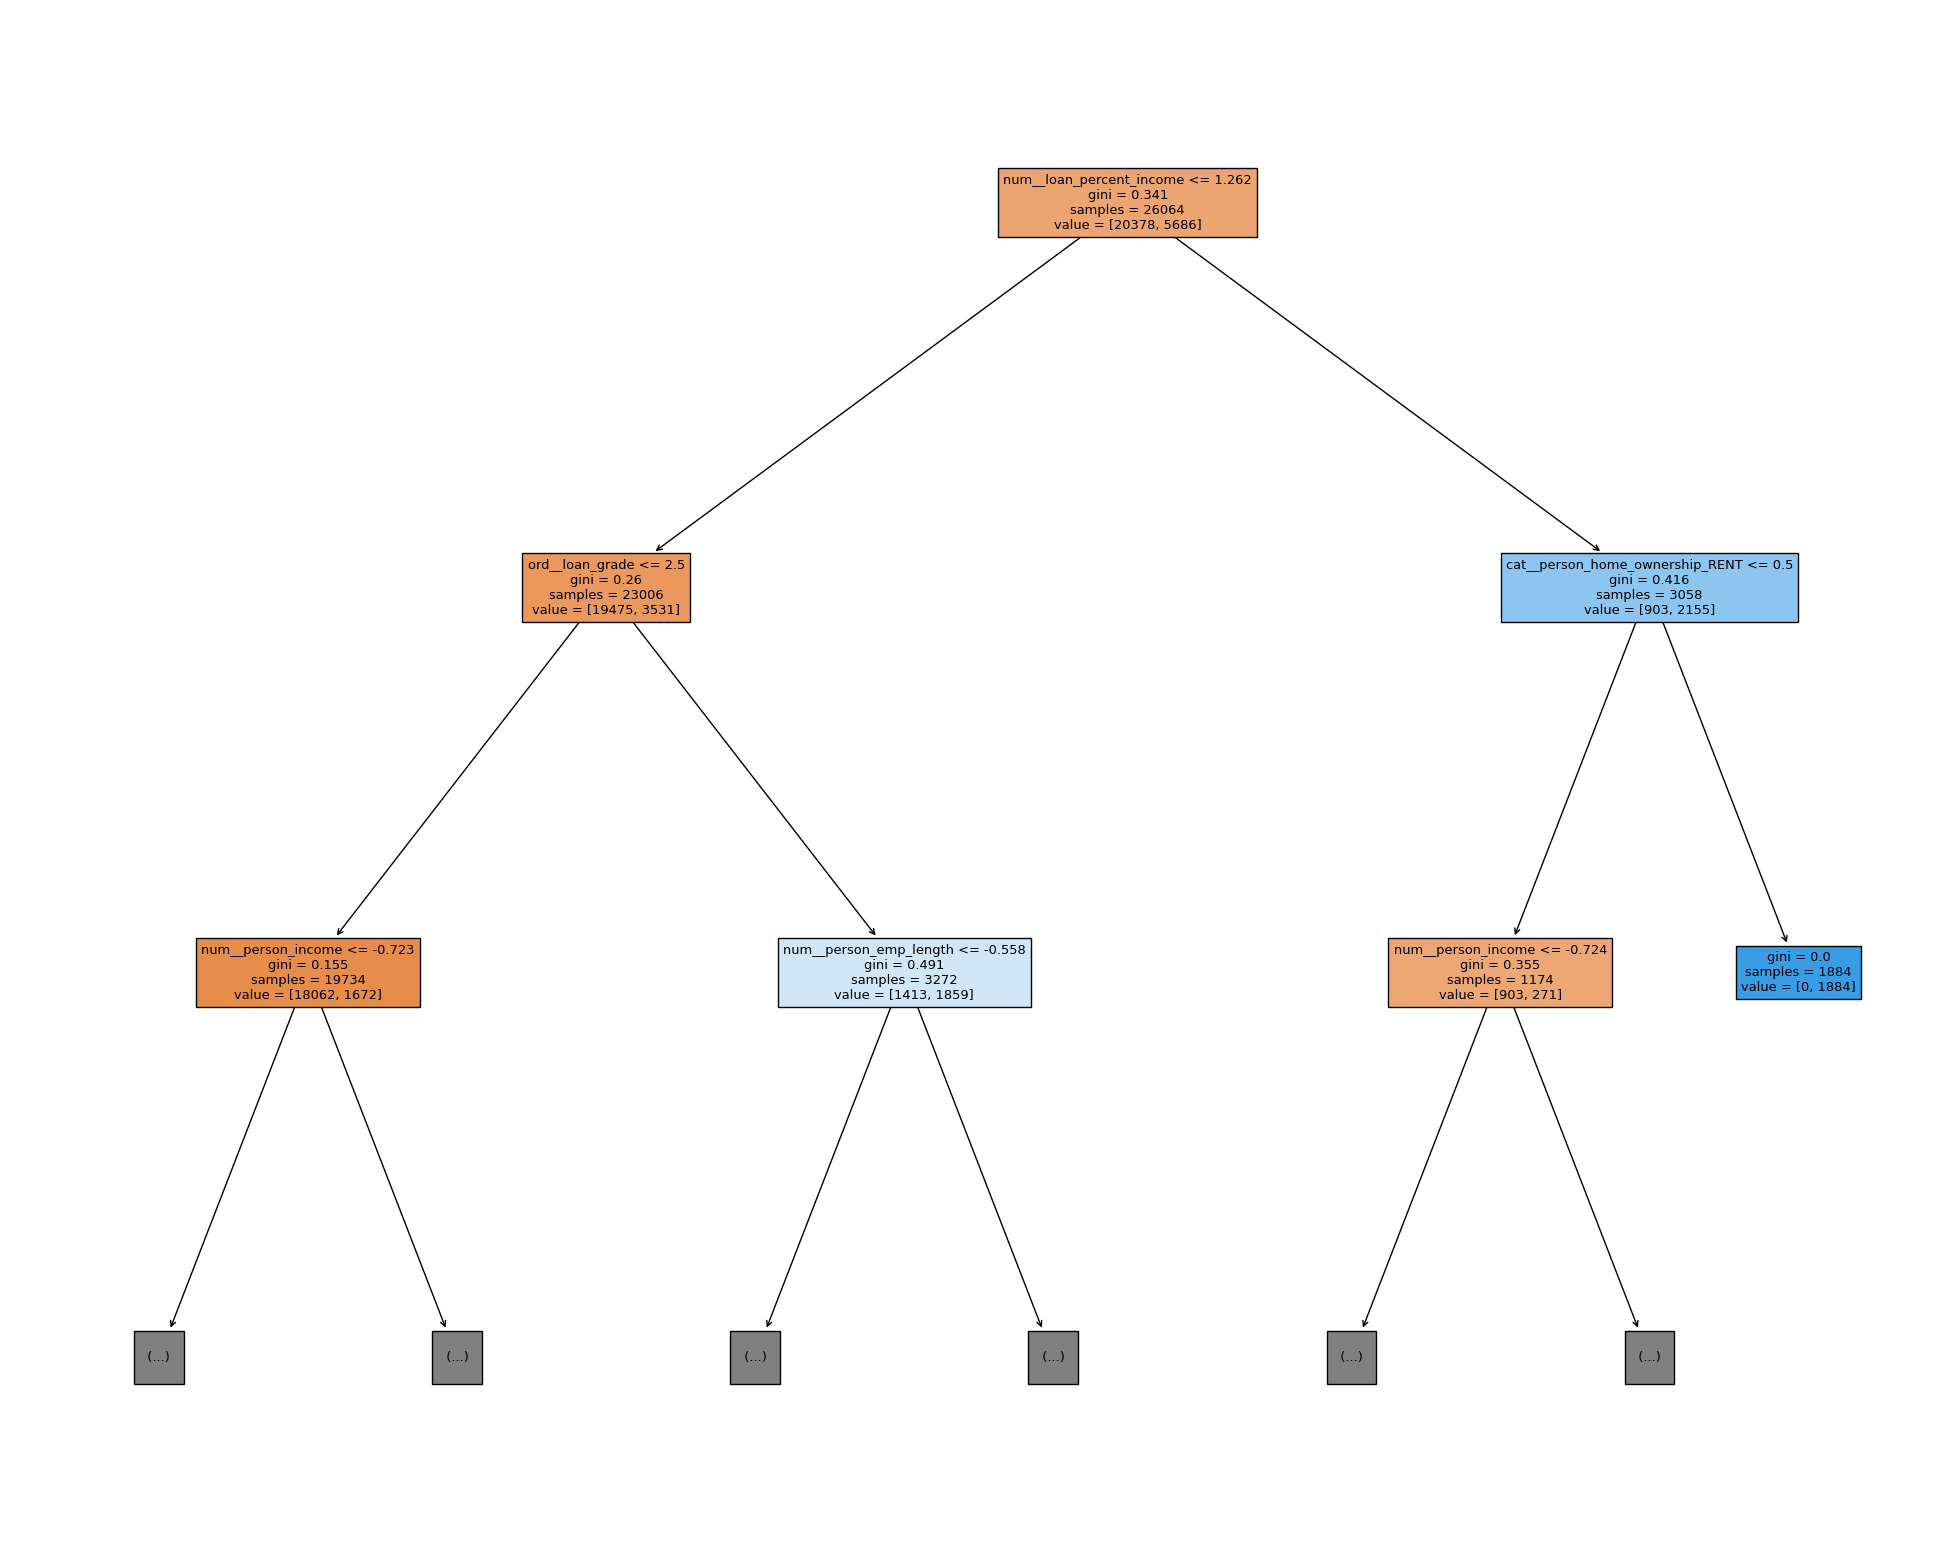

In [148]:
from sklearn import tree
#best_pipeline.named_steps['preprocessor'].get_feature_names_out()
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(best_pipeline['classifier'],       
                                feature_names= best_pipeline.named_steps['preprocessor'].get_feature_names_out(),
                                max_depth=2,
                                filled =True)
                   

In [129]:
best_pipeline.named_steps['preprocessor']

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['person_age', 'person_income',
                                  'person_emp_length', 'loan_amnt',
                                  'loan_int_rate', 'loan_percent_income',
                                  'cb_person_cred_hist_length']),
                                ('cat',
                                 Pipeline(steps=[('encoder', OneHotEncoder())]),
                                 ['loan_intent', 'person_home_ownership',
                                  'cb_person_default_on_file']),
                                ('ord',
                                 Pipeline(steps=[('encoder',
                                                  OrdinalEncoder(categories=[['A',
                                                                              'B',
                                                                              'C',
                                                                              'D',
                                                                              'E',
                                                                              'F',
                                                                              'G']]))]),
                                 ['loan_grade'])])

In [88]:
text_representation = tree.export_text(best_pipeline['classifier'])
print(text_representation)

|--- feature_5 <= 1.26
|   |--- feature_19 <= 2.50
|   |   |--- feature_1 <= -0.72
|   |   |   |--- feature_5 <= -0.14
|   |   |   |   |--- feature_9 <= 0.50
|   |   |   |   |   |--- feature_0 <= -0.03
|   |   |   |   |   |   |--- feature_1 <= -0.87
|   |   |   |   |   |   |   |--- feature_5 <= -0.56
|   |   |   |   |   |   |   |   |--- feature_8 <= 0.50
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |--- feature_8 >  0.50
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- feature_5 >  -0.56
|   |   |   |   |   |   |   |   |--- feature_3 <= -1.32
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- feature_3 >  -1.32
|   |   |   |   |   |   |   |   |   |--- feature_4 <= -0.29
|   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |--- feature_4 >  -0.29
|   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- feature_1 >  -0.8

In [99]:
import graphviz
# DOT data
dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=X_train.columns,  
                                max_depth=10,
                                class_names=y_train.columns,
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

ModuleNotFoundError: No module named 'graphviz'

In [98]:
X_train

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
15884,25,241875,MORTGAGE,4.0,EDUCATION,A,16000,7.05,0.07,N,4
15138,21,18000,RENT,5.0,PERSONAL,B,1500,12.18,0.08,N,4
7474,25,53000,MORTGAGE,10.0,MEDICAL,B,16000,12.53,0.30,N,2
18212,28,16800,OWN,NaN,MEDICAL,C,5000,13.98,0.30,N,8
6493,25,50000,MORTGAGE,2.0,VENTURE,A,10000,7.90,0.20,N,2
...,...,...,...,...,...,...,...,...,...,...,...
14621,25,98000,MORTGAGE,9.0,HOMEIMPROVEMENT,E,25000,16.45,0.26,N,4
18736,30,65000,RENT,0.0,MEDICAL,C,16000,13.06,0.25,N,8
1663,22,20000,RENT,7.0,EDUCATION,A,1675,7.74,0.08,N,3
18257,29,110000,RENT,4.0,HOMEIMPROVEMENT,E,24000,18.39,0.22,Y,8


In [77]:
y_pred = best_pipeline.predict(X_test)

In [78]:
confusion = confusion_matrix(y_test, y_pred)
TP = confusion[1, 1]  # True Positives
TN = confusion[0, 0]  # True Negatives
FP = confusion[0, 1]  # False Positives
FN = confusion[1, 0]  # False Negatives

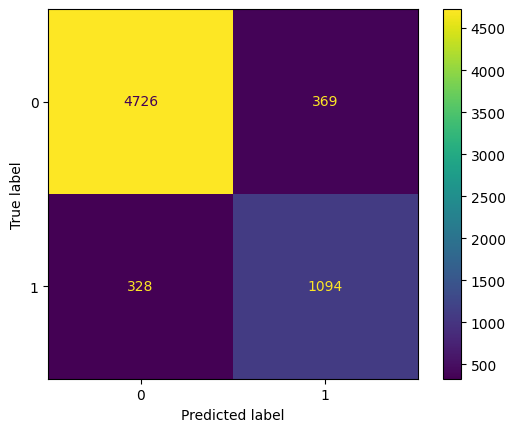

In [79]:

disp = ConfusionMatrixDisplay(confusion_matrix = confusion,
                              display_labels = pipeline.named_steps['classifier'].classes_)
disp.plot()
plt.show()

In [80]:
print('Precisão', TP/(TP + FP) )
print('Sensitividade', TP/(TP+FN))
print('Especificidade', TN/(TN+FP))
print('Acurácia', (TP+TN)/(TP+TN+FN+FP))

Precisão 0.7477785372522214
Sensitividade 0.7693389592123769
Especificidade 0.9275760549558391
Acurácia 0.8930489489028695
